## Introduction
This program aims to create a predictive model that can be used by financial institutions to automate the loan eligibility process based on customer details provided while filing an online application form. 
## Stages:
The program can be broken down into the following stages:
1. Setting up the environment
2. Loading the Data
3. Visualizing the data prior to gain any useful insights
4. Data cleaning and preparation
5. Selecting and training amodel
6. Evaluating the model

## Setting up the Environment

In [271]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay

## Loading the Data

In [272]:
#Importing the Dataset
df = pd.read_csv("data.csv")

In [273]:
#Preview the data to ensure it was loaded
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,NaN,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000.0,0.0,141.0,360.0,1.0,Urban,Y


In [274]:
#Remove Loan ID as it is unique and not needed for evaluation
df.drop(['Loan_ID'], axis=1, inplace=True)

## Visualizing the Data

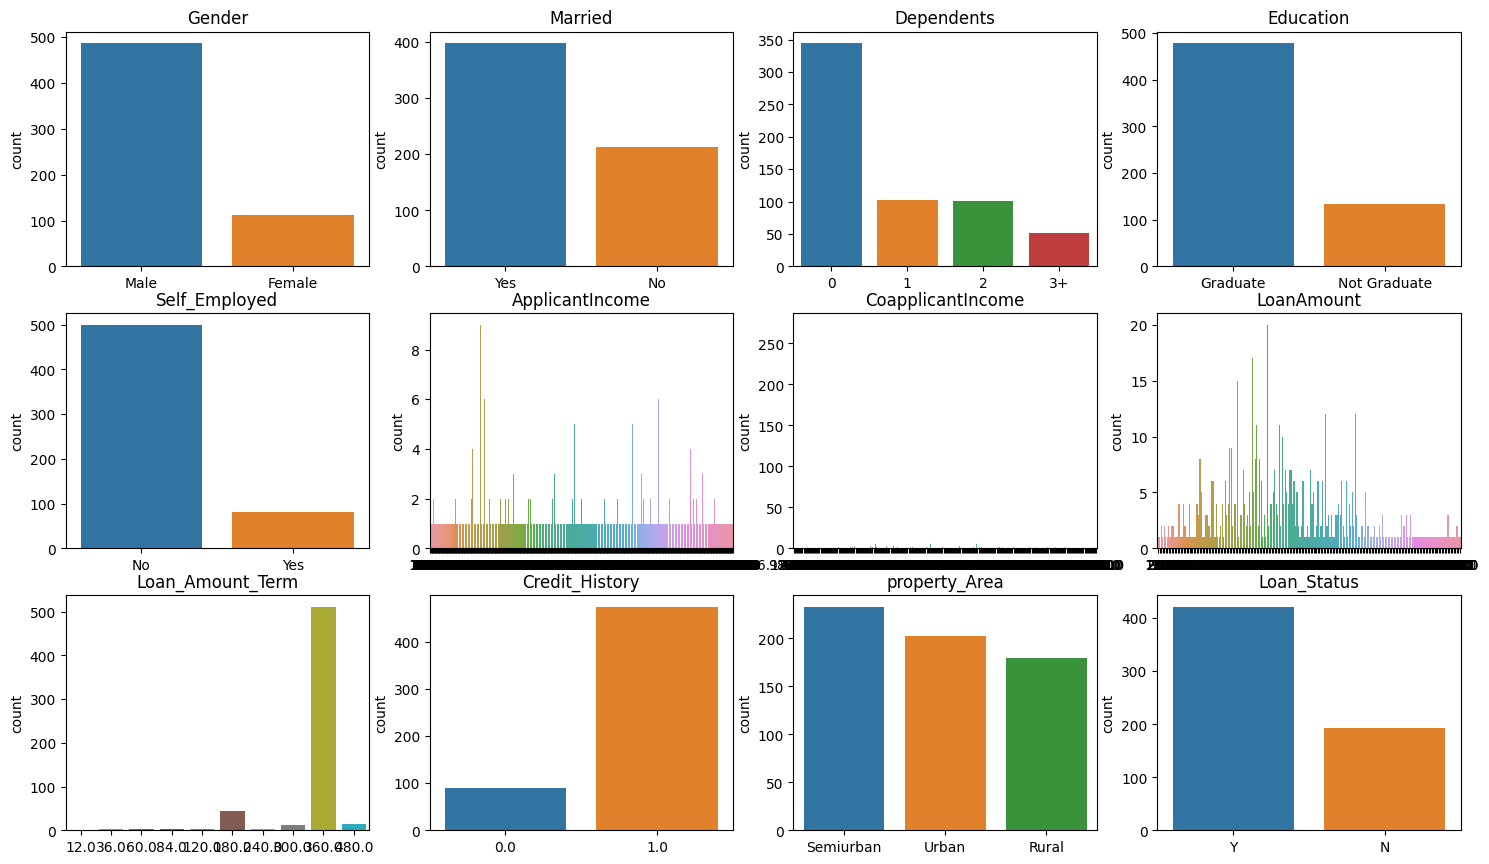

In [275]:
#Initial visualization of the dataset
obj_or_float = (df.dtypes == 'object') | (df.dtypes == 'float64')
object_cols = list(obj_or_float[obj_or_float].index)
plt.figure(figsize=(18,36))
index = 1

for col in object_cols:
  y = df[col].value_counts()
  plt.subplot(10,4,index)
  plt.xticks()
  bp = sns.barplot(x=list(y.index), y=y)
  bp.set_title(col)
  index +=1

In [276]:
# Identifying correlation between features and target
correlations = {}

#Transform into Loan_Statues into integer codes
if df['Loan_Status'].dtype == 'object':
    df['Loan_Status'] = df['Loan_Status'].astype('category').cat.codes

#Iterate through the features and find the correlation to target
for feature in df.columns:
    if feature != 'Loan_Status':
        if df[feature].dtype == 'object':  # For categorical features
            feature_series = df[feature].astype('category').cat.codes
            correlation = feature_series.corr(df['Loan_Status'])
        else:  # For continuous features
            correlation = df[feature].corr(df['Loan_Status'])
        correlations[feature] = correlation

# Sort the features based on absolute correlation values
sorted_correlations = dict(sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True))
print(sorted_correlations)

{'Credit_History': 0.56167815746538, 'Education': -0.0879433081041433, 'Married': 0.0755465115481422, 'CoapplicantIncome': -0.059291917039217656, 'LoanAmount': -0.03731776869979421, 'property_Area': 0.032111984628800216, 'Loan_Amount_Term': -0.021267658123863036, 'Gender': 0.019157581930082147, 'Dependents': 0.014262777059577693, 'Self_Employed': -0.011331780688728548, 'ApplicantIncome': -0.0049637409453227675}


## Correlation
The computation shows that Credit_History, Married, and Education had the three strongest correlation scores. If the dataset were larger, focusing on these features may be benefitial. However, after testing, there was no significant difference shown when the features were reduced.

In [277]:
#Checking the number of missing information for each feature
df.isna().sum()

Gender               15
Married               3
Dependents           15
Education             1
Self_Employed        32
ApplicantIncome       2
CoapplicantIncome     1
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
property_Area         0
Loan_Status           0
dtype: int64

## Data Cleaning and Preparation

In [278]:
'''
Since Gender, Marital Satus, Education, Self Employed, and Credit History are either binary or categorical, 
I will fill in the missing values with the mode for each feature.
'''
df['Gender'].fillna(df['Gender'].mode().iloc[0], inplace=True)
df['Married'].fillna(df['Married'].mode().iloc[0], inplace=True)
df['Education'].fillna(df['Education'].mode().iloc[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode().iloc[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode().iloc[0], inplace=True)


In [279]:
'''
Since Dependents and Loan_Amount_Term are discreet numerical values, I will compute the median average and round 
to the nearest whole number.
'''
# Change 3+ to a 3
df['Dependents'].replace('3+', 3, inplace=True)

# Convert non-NaN values to integers
df['Dependents'] = df['Dependents'].apply(lambda x: int(x) if pd.notnull(x) else x)

#Fill in NaN values with the mean for each column
df['Dependents'].fillna(round(df['Dependents'].median()), inplace=True)
df['ApplicantIncome'].fillna(round(df['ApplicantIncome'].median()), inplace=True)
df['LoanAmount'].fillna(round(df['LoanAmount'].median()), inplace=True)
df['Loan_Amount_Term'].fillna(round(df['Loan_Amount_Term'].median()), inplace=True)

In [280]:
'''
Since there is only one instance where the CoapplicantIncome is missing and the dataset
does not state whether there was a coapplicant, I will replace the missing data with a 0
as this is the most concervative estimate.
'''
df['CoapplicantIncome'].fillna(0, inplace=True)

In [281]:
#Verifying that there is no missing data
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
property_Area        0
Loan_Status          0
dtype: int64

In [282]:
#Converting nomial values to binary
df.Gender = df.Gender.replace({"Male": 1, "Female" : 0})
df.Married = df.Married.replace({"Yes": 1, "No" : 0})
df.Education = df.Education.replace({"Graduate": 1, "Not Graduate" : 0})
df.Self_Employed = df.Self_Employed.replace({"Yes": 1, "No" : 0})
df.Loan_Status = df.Loan_Status.replace({"Y": 1, "N" : 0})

In [283]:
'''
Since Dependents and Property_Area has more than 2 possible values, I will use LabelEncoder
'''
df['property_Area'] = LabelEncoder().fit_transform(df['property_Area'])
df['Dependents'] = LabelEncoder().fit_transform(df['Dependents'])

In [284]:
#Preview the cleaned data
df.head(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,property_Area,Loan_Status
0,1,0,0,1,0,5849.0,0.0,128.0,360.0,1.0,2,1
1,1,1,1,1,0,3806.0,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,1,1,3000.0,0.0,66.0,360.0,1.0,2,1
3,1,1,0,0,0,2583.0,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,1,0,6000.0,0.0,141.0,360.0,1.0,2,1
5,1,1,2,1,1,5417.0,4196.0,267.0,360.0,1.0,2,1
6,1,1,0,0,0,2333.0,1516.0,95.0,360.0,1.0,2,1
7,1,1,3,1,0,3036.0,2504.0,158.0,360.0,0.0,1,0
8,1,1,2,1,0,4006.0,1526.0,168.0,360.0,1.0,2,1
9,1,1,1,1,0,12841.0,10968.0,349.0,360.0,1.0,1,0


In [285]:
'''
Split the dataset into training and testing sets and separate the Features from the Target
'''

X = df.drop('Loan_Status', axis=1)  # Features
y = df['Loan_Status']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [286]:
#Normalize the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [287]:
#Find the optimal parameters using GridSeachCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=5, verbose=2, return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

#Print out the best parameters found
grid_search.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ............C=0.1, degree=2, gamma=1, kernel=linear; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=

{'C': 1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}

In [288]:
#Storing the best hyperparameters found
best_params = grid_search.best_params_

# Using the best hyperparameters to initialize a new SVC model
best_svm = SVC(C=best_params["C"], kernel=best_params["kernel"], gamma=best_params["gamma"], probability=True, degree=best_params["degree"])

## Training the Model

In [289]:
#Training
best_svm.fit(X_train_scaled, y_train)

SVC(C=1, degree=2, gamma=0.01, probability=True)

### Evaluation using Training Data

In [290]:
#Evaluating using training data
y_pred_train = best_svm.predict(X_train_scaled)

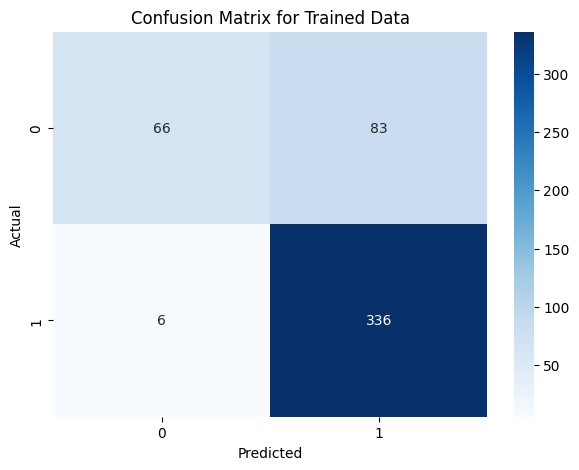

In [291]:
#Confusion matrix of training data
cm_svm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(7,5))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Trained Data')
plt.show()

Accuracy: 0.8187372708757638
ROC: 0.7127045802425527
              precision    recall  f1-score   support

           0       0.92      0.44      0.60       149
           1       0.80      0.98      0.88       342

    accuracy                           0.82       491
   macro avg       0.86      0.71      0.74       491
weighted avg       0.84      0.82      0.80       491



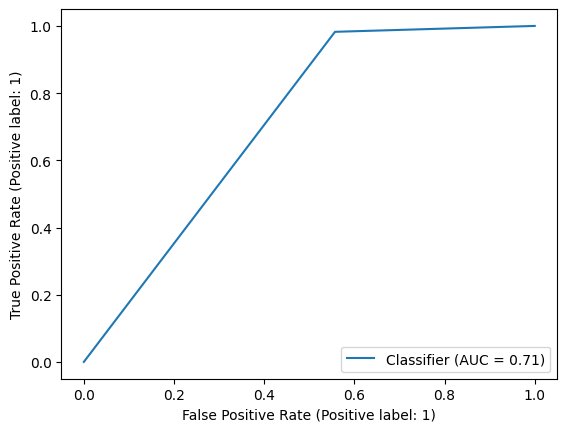

In [292]:
# Print accuracy
print("Accuracy:", accuracy_score(y_train, y_pred_train))

#Calculate ROC and Display the graph
print("ROC:", roc_auc_score(y_train, y_pred_train))
RocCurveDisplay.from_predictions(y_train, y_pred_train)

# Print classification report
print(classification_report(y_train, y_pred_train))

### Evaluating with Testing Data

In [293]:
# Predict on the testing data
y_pred_test = best_svm.predict(X_test_scaled)

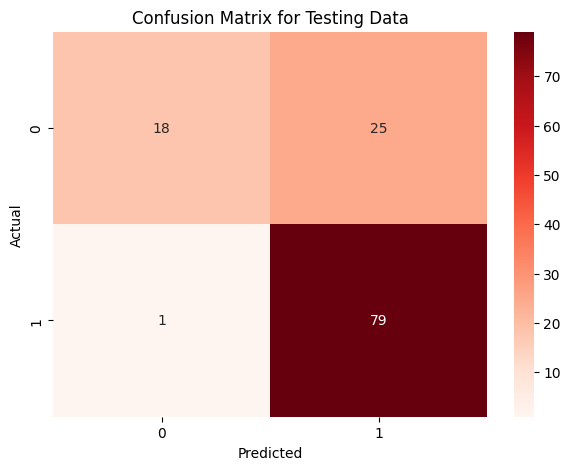

In [294]:
# Display confusion matrix of testing data
cm_svm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(7,5))
sns.heatmap(cm_svm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Testing Data')
plt.show()

Accuracy: 0.7886178861788617
ROC: 0.7030523255813954
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



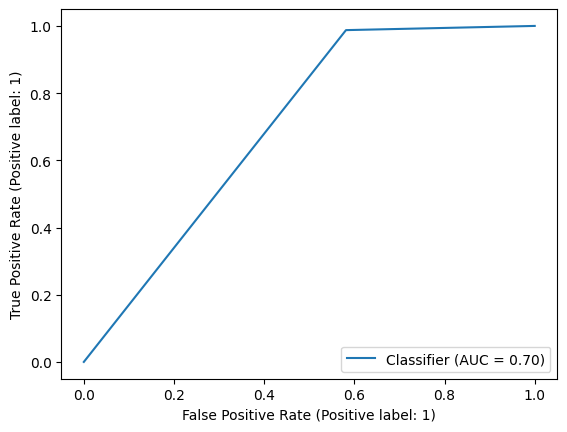

In [295]:
# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_test))

#Calculate ROC and Display the graph
print("ROC:", roc_auc_score(y_test, y_pred_test))
RocCurveDisplay.from_predictions(y_test, y_pred_test)

# Print classification report
print(classification_report(y_test, y_pred_test))

# Conclusion
After training, the model displayed an accuracy of 79% with an area under the curve of 0.70 when evaluated against the testing dataset, both of which are poor results. The model did not fair much better with the training set, which suggests underfitting. The confusion matrix for both training and testing datasets shows that the model predominantly predicts loan approval. Additional tuning is needed to optimize this model. Alternate training algorithms were tested:Random Forest, Naive Bayes, and adding polynomial features. However, none of them produced better results. This leads me to believe that a larger dataset is needed to improve the model. 